In [1]:
%matplotlib inline


Interpreting linear models
==========================

Linear models are not that easy to interpret when variables are
correlated.

See also the [statistics chapter](http://www.scipy-lectures.org/packages/statistics/index.html) of the
[scipy lecture notes](http://www.scipy-lectures.org).




Data on wages
--------------

We first download and load some historical data on wages



In [2]:
import os
import pandas

# Python 2 vs Python 3:
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

if not os.path.exists('wages.txt'):
    # Download the file if it is not present
    urlretrieve('http://lib.stat.cmu.edu/datasets/CPS_85_Wages',
                'wages.txt')

# Give names to the columns
names = [
    'EDUCATION: Number of years of education',
    'SOUTH: 1=Person lives in South, 0=Person lives elsewhere',
    'SEX: 1=Female, 0=Male',
    'EXPERIENCE: Number of years of work experience',
    'UNION: 1=Union member, 0=Not union member',
    'WAGE: Wage (dollars per hour)',
    'AGE: years',
    'RACE: 1=Other, 2=Hispanic, 3=White',
    'OCCUPATION: 1=Management, 2=Sales, 3=Clerical, 4=Service, 5=Professional, 6=Other',
    'SECTOR: 0=Other, 1=Manufacturing, 2=Construction',
    'MARR: 0=Unmarried,  1=Married',
]

short_names = [n.split(':')[0] for n in names]
data = pandas.read_csv('wages.txt', skiprows=27, skipfooter=6, sep=None,
                       header=None, engine='python')
data.columns = short_names

# Log-transform the wages, as they typically increase with
# multiplicative factors
import numpy as np
data['WAGE'] = np.log10(data['WAGE'])

The challenge of correlated features
--------------------------------------------

Plot scatter matrices highlighting the links between different
variables measured



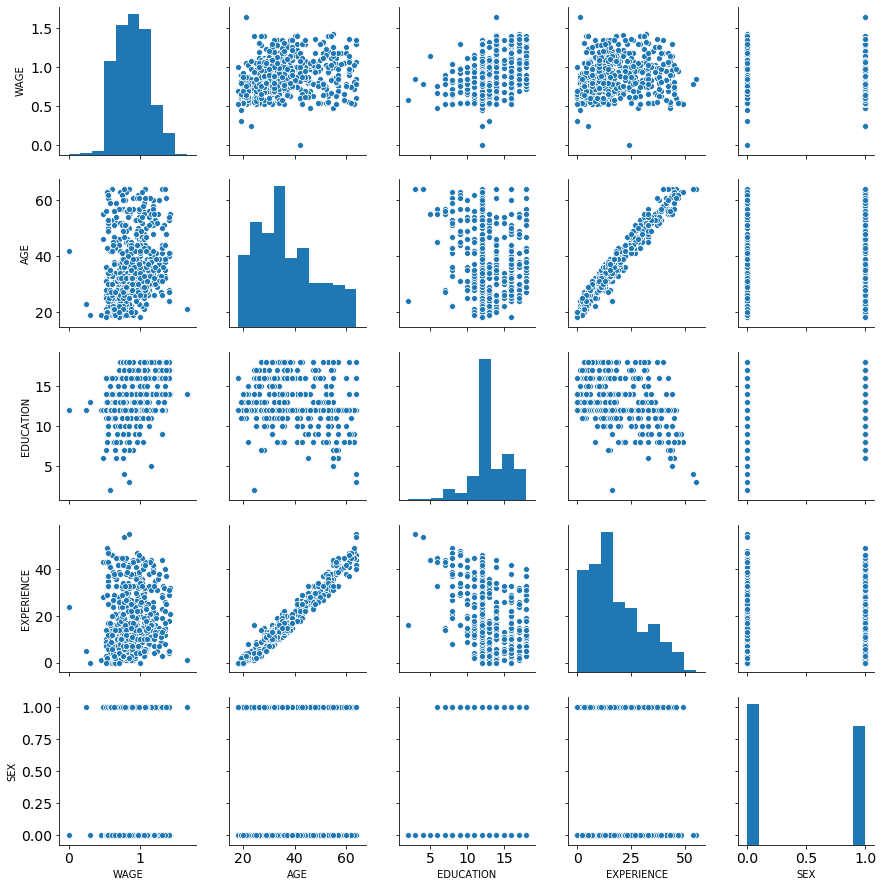

In [3]:
import seaborn
# The simplest way to plot a pairplot
seaborn.pairplot(data, vars=['WAGE', 'AGE', 'EDUCATION', 'EXPERIENCE', 'SEX'])

A fancier pair plot



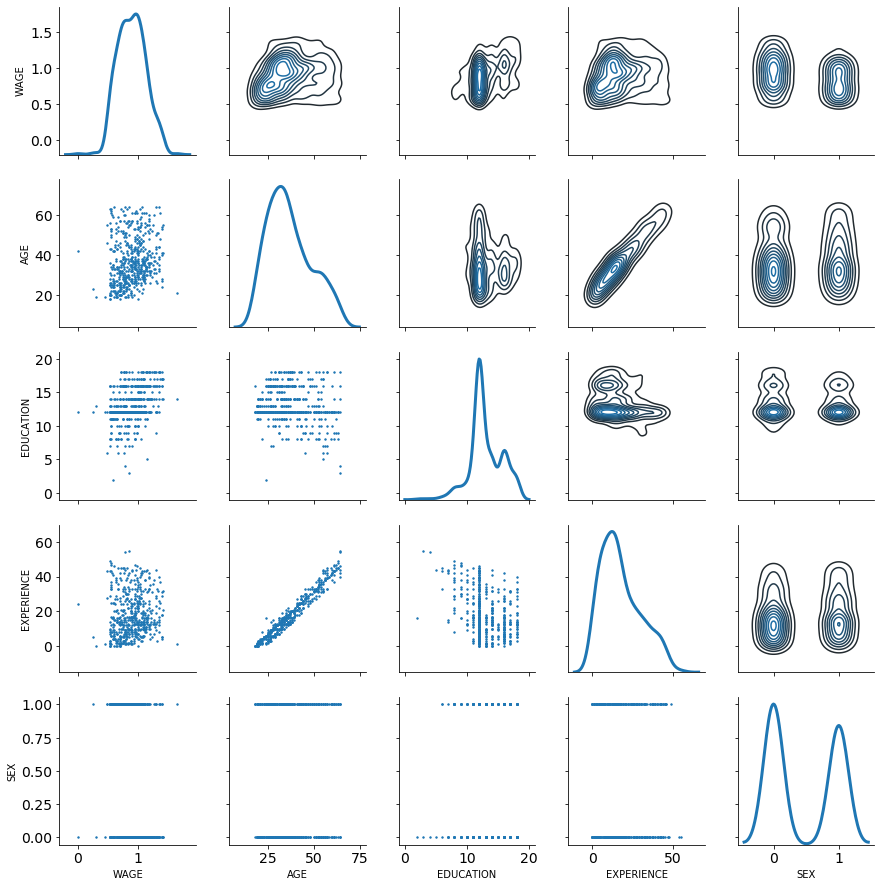

In [4]:
from matplotlib import pyplot as plt

g = seaborn.PairGrid(data,
                     vars=['WAGE', 'AGE', 'EDUCATION', 'EXPERIENCE', 'SEX'],
                     diag_sharey=False)
g.map_upper(seaborn.kdeplot)
g.map_lower(plt.scatter, s=2)
g.map_diag(seaborn.kdeplot, lw=3)

Note that age and experience are highly correlated

A link between a single feature and the target is a *marginal* link.


Univariate feature selection selects on marginal links.

Linear model compute *conditional* links: removing the effects of other
features on each feature. This is hard when features are correlated.



Coefficients of a linear model
--------------------------------------------




In [5]:
from sklearn import linear_model
features = [c for c in data.columns if c != 'WAGE']
X = data[features]
y = data['WAGE']
ridge = linear_model.RidgeCV()
ridge.fit(X, y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

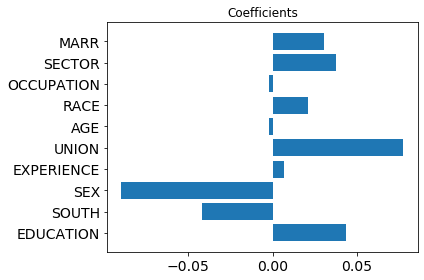

In [6]:
# Visualize the coefs
coefs = ridge.coef_
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), features)
plt.title("Coefficients")
plt.tight_layout()

**Scaling coefficients**: coefs cannot easily be compared if X is not
standardized: they should be normalized to the variance of X: the
greater the variance of a feature, the large the impact of the
corresponding coefficent on the output.

If the different features have differing, possibly arbitrary, scales,
then scaling the coefficients by the feature scale often helps
interpretation.



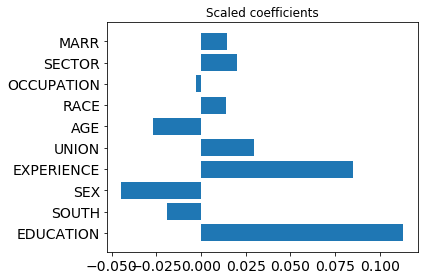

In [7]:
X_std = X.std()
plt.figure(figsize=(6, 4))
plt.barh(np.arange(coefs.size), coefs * X_std)
plt.yticks(np.arange(coefs.size), features)
plt.title("Scaled coefficients")
plt.tight_layout()

Now the age and experience can be better compared: and experience does
appear as more important than age.



When features are not too correlated and there is plenty of samples,
this is the well-known regime of standard statistics in linear models.
Machine learning is not needed, and statsmodels is a great tool (see the
[statistics chapter in scipy-lectures](http://www.scipy-lectures.org/packages/statistics/index.html))



The effect of regularization
--------------------------------------------

Sparse models use l1 regularization to puts some variables to
zero. This can often help interpretation



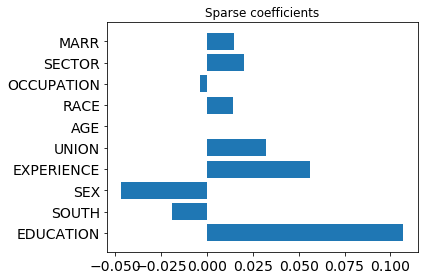

In [8]:
lasso = linear_model.LassoCV(max_iter=100000, cv=5)
lasso.fit(X, y)

coefs = lasso.coef_
plt.barh(np.arange(coefs.size), coefs * X_std)
plt.yticks(np.arange(coefs.size), features)
plt.title("Sparse coefficients")
plt.tight_layout()

When two variables are very correlated (such as age and experience), it
will put arbitrarily one or the other to zero depending on their SNR.

Here we can see that age probably overshadowed experience.



Stability to gauge significance
--------------------------------

Stability of coefficients when perturbing the data helps giving an
informal evaluation of the significance of the coefficients. Note that
this is not significance testing in the sense of p-values, as a model
that returns coefficients always at one indepently of the data will
appear as very stable though it clearly does not control for false
detections.

We can do this in a cross-validation loop, using the argument
"return_estimator" of `sklearn.model_selection.cross_validate`
which has been added in version 0.20 of scikit-learn:



In [9]:
from sklearn.model_selection import cross_validate

### With the lasso estimator




In [12]:
cv_lasso = cross_validate(lasso, X, y, return_estimator=True, cv=10)


In [13]:
coefs_ = [estimator.coef_ for estimator in cv_lasso['estimator']]

Plot the results with seaborn:



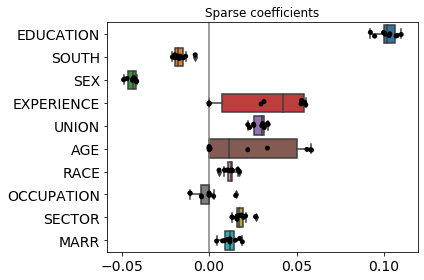

In [14]:
coefs_ = pandas.DataFrame(coefs_, columns=features) * X_std
plt.figure(figsize=(6, 4))
seaborn.boxplot(data=coefs_, orient='h')
seaborn.stripplot(data=coefs_, orient='h', color='k')
plt.axvline(x=0, color='.5')  # Add a vertical line at 0
plt.title('Sparse coefficients')
plt.tight_layout()

### With the ridge estimator


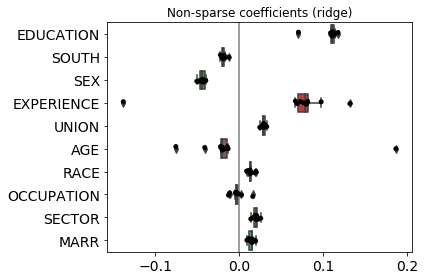

In [15]:
cv_ridge = cross_validate(ridge, X, y, return_estimator=True, cv=10)
coefs_ = [estimator.coef_ for estimator in cv_ridge['estimator']]

coefs_ = pandas.DataFrame(coefs_, columns=features) * X_std
plt.figure(figsize=(6, 4))
seaborn.boxplot(data=coefs_, orient='h')
seaborn.stripplot(data=coefs_, orient='h', color='k')
plt.axvline(x=0, color='.5') # Add a vertical line at 0
plt.title('Non-sparse coefficients (ridge)')
plt.tight_layout()

The story is different. Note also that lasso coefficients are much more
instable than the ridge. It is often the case that sparse models are
unstable.



### Which is the truth?


Note the difference between the lasso and the ridge estimator: we do
not have enough data to perfectly estimate conditional relationships,
hence the prior (ie the regularization) makes a difference, and its is
hard to tell from the data which is the "truth".

One reasonnable model-selection criterion is to believe most the model
that predicts best. For this, we can inspect the prediction scores
obtained via the cross-validation



Text(0.5, 1.0, 'Model comparison')

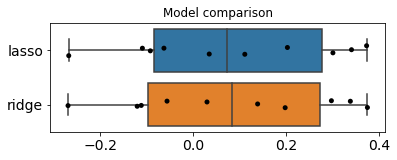

In [16]:
scores = pandas.DataFrame({'lasso': cv_lasso['test_score'],
                           'ridge': cv_ridge['test_score']})
plt.figure(figsize=(6, 2))
seaborn.boxplot(data=scores, orient='h')
seaborn.stripplot(data=scores, orient='h', color='k')
plt.title("Model comparison")

Note also that the limitations of cross-validation explained previously
still apply. Ideally, we should use a ShuffleSplit cross-validation
object to sample many times and have a better estimate of the
posterior, both for the coefficients and the test scores.

#### Conclusion on factors of wages?


As always, concluding is hard. That said, it seems that we should
prefer the scaled ridge coefficients.

Hence, the most important factors of wage are education and
experience, followed by sex: at the same education and experience
females earn less than males. Note that this last statement is a
statement about the link between wage and sex, conditional on education
and experience.



Interpreting random forests
=======================

Interpreting random forests can be done through feature importance. This index explain how much a feature is used to split a tree. This is also known as the Gini importance.



In [ ]:
from sklearn import ensemble

forest = ensemble.RandomForestRegressor(n_estimators=100)
forest.fit(X, y)

# Visualize the feature importance
importance = forest.feature_importances_
from matplotlib import pyplot as plt
plt.barh(np.arange(importance.size), importance)
plt.yticks(np.arange(importance.size), features)
plt.tight_layout()

Feature importances are a proxy for the mutual information between the
feature and the target, conditionally on the other features. The
conditioning is difficult and not well controlled.

Higher-cardinality categorical variables will have larger
feature importances


In [ ]:
from sklearn.metrics import per